# Agent-Based Model on Cat Behavior

### In our project we decided to create 4 total cats with several different traits ranging from hunger levels to personality traits
### Based on the traits each cat has will determine their interactions with each other, objects in the room, and people who walk in the room

In [101]:
from IPython.display import HTML
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

To start here is a legend of all potential personality traits and needs our cats may have.

In [129]:
legend= {'Calm' : 'Very relaxed; Gets along with all cats; Gets along with all humans',
         'Shy' : 'Takes a while to warm up, hides away; Does not interact with other cats or humans' ,
         "Playful" : 'Wants to hunt and play; Gets along with Calm cats, Fights with Aggressive cats; Gets along with all humans' ,
         'Aggressive' : 'Will hiss, growl, and bite; Fights with all cats; Fights with humans' 
        } 


#
# Trait	Behavior Around Others
# Shy ≥ 2	Avoids other cats — moves away if another cat is nearby
# Aggressive ≥ 2	Approaches other cats — initiates "conflict" when nearby
# Calm ≥ 2	Doesn't react to other cats (neutral)
# Playful ≥ 2	Moves toward cats (seeks interaction), unless the other cat is aggressive

Because we want our interactions to be as random and organic as possible we will create a class that will help cat decisions!

In [135]:
import random

class Cat:
    def __init__(self, name, personality, image_path):
        self.name = name
        self.image_path = image_path
        self.personality = personality

        self.needs = {'hunger': 0, 'sleep': 0, 'potty': 0}
        self.activity = "roam"

        self.x, self.y = 15, 137  # Start at bed
        self.target = (self.x, self.y)
        self.speed = 1.5

        self.history = []

        # Trackers for new logic
        self.time_roaming = 0
        self.time_playing = 0
        self.last_eaten = -1
        self.last_pottied = -1

    def update_needs(self):
        for need in self.needs:
            self.needs[need] += 1

    def decide_action(self, hour):
        # Sleep at night unless aggressive/playful
        if 22 <= hour or hour < 6:
            if self.personality.get("Aggressive", 0) < 2 and self.personality.get("Playful", 0) < 2:
                self.activity = 'sleeping'
                self.target = (15, 137)
                self.time_roaming = 0
                self.time_playing = 0
                return

        # Force eat if roaming too long without food
        if self.time_roaming >= 3 and self.last_eaten < hour - 3:
            self.do_action("eat")
            return

        # Force sleep after eat + potty + roaming or 2+ plays
        if (self.last_eaten != -1 and self.last_pottied != -1 and
            (self.activity == "roam" or self.time_playing >= 2)):
            self.do_action("sleep")
            self.time_roaming = 0
            self.time_playing = 0
            return

        # Normal priority logic
        priorities = {
            'eat': self.needs['hunger'],
            'sleep': self.needs['sleep'],
            'bathroom': self.needs['potty'],
            'play': self.personality.get('Playful', 0)
        }
        chosen = max(priorities, key=priorities.get)
        self.do_action(chosen)

    def do_action(self, action):
        # Update roaming/playing counters
        if action == "roam":
            self.time_roaming += 1
        else:
            self.time_roaming = 0

        if action == "play":
            self.time_playing += 1
        else:
            self.time_playing = 0

        # Action-specific behaviors
        if action == 'eat':
            self.needs['hunger'] = 0
            self.needs['potty'] += 2
            self.activity = 'eating'
            self.target = (15, 12)
        elif action == 'sleep':
            self.needs['sleep'] = max(0, self.needs['sleep'] - 3)
            self.activity = 'sleeping'
            self.target = (15, 137)
        elif action == 'bathroom':
            self.needs['potty'] = 0
            self.activity = 'bathroom'
            self.target = (140, 137)
        elif action == 'play':
            self.needs['hunger'] += 2
            self.needs['sleep'] += 2
            self.needs['potty'] += 1
            self.activity = 'playing'
            self.target = (140, 12)
        else:
            self.activity = 'roam'
            self.target = self.random_target()

    def move(self):
        dx = self.target[0] - self.x
        dy = self.target[1] - self.y
        dist = (dx**2 + dy**2)**0.5
        if dist > 1:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
            self.x = min(max(self.x, 0), 150)
            self.y = min(max(self.y, 0), 150)

    def interact_with(self, other_cat):
        if self == other_cat:
            return
        dist = ((self.x - other_cat.x)**2 + (self.y - other_cat.y)**2)**0.5
        if dist < 25:
            if self.personality.get("Shy", 0) >= 2:
                self.activity = "avoiding"
                dx = self.x - other_cat.x
                dy = self.y - other_cat.y
                self.target = (self.x + dx, self.y + dy)
            elif self.personality.get("Aggressive", 0) >= 2:
                self.activity = "confronting"
                self.target = (other_cat.x, other_cat.y)
            elif self.personality.get("Playful", 0) >= 2 and other_cat.personality.get("Aggressive", 0) < 2:
                self.activity = "approaching"
                self.target = (other_cat.x, other_cat.y)

    def log_state(self, hour):
        if self.activity == "eating":
            self.last_eaten = hour
        elif self.activity == "bathroom":
            self.last_pottied = hour

        summary = f"Hour {hour}: {self.name} is {self.activity} at ({int(self.x)}, {int(self.y)})"
        self.history.append({
            'hour': hour,
            'x': self.x,
            'y': self.y,
            'activity': self.activity,
            'needs': self.needs.copy(),
            'summary': summary
        })

    def random_target(self):
        return (random.randint(10, 140), random.randint(10, 140))

    def __repr__(self):
        return f"Cat({self.name}, activity={self.activity})"


In [113]:
cats = [
    Cat('Tito', {
        'Playful': 2,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 1
    }, "tito.png"),

    Cat('Tobi', {
        'Playful': 1,
        'Shy': 2,
        'Calm': 1,
        'Aggressive': 1
    }, "tobi.png"),

    Cat('Dumpling', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 2,
        'Aggressive': 1
    }, "dumpling.png"),

    Cat('Jiji', {
        'Playful': 1,
        'Shy': 1,
        'Calm': 1,
        'Aggressive': 2
    }, "jiji.png")
]


Here you can find out who our cats are and what their personality traits are!

The start of the simulation for the visualization.

In [137]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# 📦 Cache loaded images
cat_images = {}

# 📸 Load image with optional zoom
def get_cat_image(path, zoom=0.15):
    if path not in cat_images:
        cat_images[path] = OffsetImage(mpimg.imread(path), zoom=zoom)
    return cat_images[path]

# 🛏️ Draw environment layout
def draw_environment(ax):
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_title("Cat Environment Layout")

    # Add zones
    ax.add_patch(patches.Rectangle((0, 125), 30, 25, edgecolor='blue', facecolor='lightblue'))
    ax.text(2, 140, "Bed", fontsize=10, color='blue')

    ax.add_patch(patches.Rectangle((125, 125), 30, 25, edgecolor='gray', facecolor='lightgray'))
    ax.text(132, 140, "Litter", fontsize=10, color='gray')

    ax.add_patch(patches.Rectangle((0, 0), 30, 25, edgecolor='green', facecolor='lightgreen'))
    ax.text(2, 10, "Food", fontsize=10, color='green')

    ax.add_patch(patches.Rectangle((125, 0), 30, 25, edgecolor='purple', facecolor='plum'))
    ax.text(128, 10, "Play", fontsize=10, color='purple')

# 🐱 Add cats to the plot (static or initial state)
def add_cats_to_plot(ax, cat_data, bed_center=(15, 137), zoom=0.15):
    offsets = [(-5, 3), (5, 3), (-5, -3), (5, -3)]  # prevent overlap
    for (name, img_file), (dx, dy) in zip(cat_data, offsets):
        img = get_cat_image(img_file, zoom)
        ab = AnnotationBbox(img, (bed_center[0] + dx, bed_center[1] + dy), frameon=False)
        ax.add_artist(ab)
        ax.text(bed_center[0] + dx + 1, bed_center[1] + dy + 1, name, fontsize=8)


In [139]:
def update(hour):
    ax.clear()
    draw_environment(ax)
    ax.set_title(f"Hour {hour}")

    hour_data = log_df[log_df['hour'] == hour]
    for _, row in hour_data.iterrows():
        img = get_cat_image(row['name'].lower() + ".png")
        ab = AnnotationBbox(img, (row['x'], row['y']), frameon=False)
        ax.add_artist(ab)
        ax.text(row['x'] + 1, row['y'] + 1, row['name'], fontsize=8)

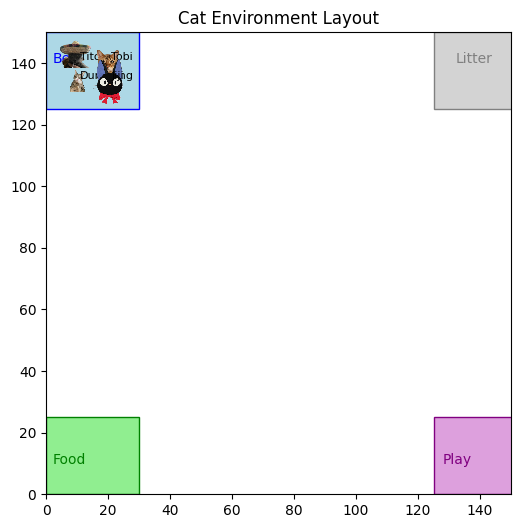

In [141]:
cat_data = [
    ("Tito", "tito.png"),
    ("Tobi", "tobi.png"),
    ("Dumpling", "dumpling.png"),
    ("Jiji", "jiji.png")
]

fig, ax = plt.subplots(figsize=(6, 6))
draw_environment(ax)
add_cats_to_plot(ax, cat_data)
plt.show()
